In [ ]:
!pip install mplfinance

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import mplfinance as mpf

In [2]:
def convert_roc_date(roc_date):
    try:
        year, month, day = map(int, roc_date.split('/'))
        western_year = year + 1911
        return f"{western_year}-{month:02d}-{day:02d}"
    except ValueError:
        return None

stock_id = "2330"
date = "20240901"

In [3]:
def fetch_twse_stock_data(stock_id, date):
    url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock_id}"
    response = requests.get(url)
    data = response.json()
    if data['stat'] == 'OK':
        df = pd.DataFrame(data['data'], columns=data['fields'])
        df['Date'] = df['日期'].apply(convert_roc_date)
        df['Date'] = pd.to_datetime(df['Date'])
        df['Close'] = pd.to_numeric(df['收盤價'].str.replace(',', ''), errors='coerce')
        df['Open'] = pd.to_numeric(df['開盤價'].str.replace(',', ''), errors='coerce')
        df['High'] = pd.to_numeric(df['最高價'].str.replace(',', ''), errors='coerce')
        df['Low'] = pd.to_numeric(df['最低價'].str.replace(',', ''), errors='coerce')
        df["Volume"] = pd.to_numeric(df['成交股數'].str.replace(',', ''), errors='coerce')
        df = df.drop(columns=['收盤價', '開盤價', '最高價', '最低價', '成交股數', '日期', '成交金額', '漲跌價差', '成交筆數'])
        df = df.set_index("Date")
        return df
    else:
        print("Could not fetch data from twse!")
        return None

In [4]:
df_twse = fetch_twse_stock_data(stock_id, date)
df_twse

,Close,Open,High,Low,Volume
Date,,,,,
2024-09-02,948.0,950.0,955.0,943.0,19272593
2024-09-03,940.0,948.0,952.0,939.0,23205623
2024-09-04,889.0,894.0,905.0,888.0,93169835
2024-09-05,902.0,907.0,915.0,900.0,34147890
2024-09-06,918.0,909.0,918.0,903.0,28248063
2024-09-09,899.0,892.0,900.0,891.0,38448946
2024-09-10,904.0,907.0,911.0,901.0,34312646
2024-09-11,901.0,906.0,906.0,900.0,19513256
2024-09-12,940.0,936.0,944.0,928.0,43749260


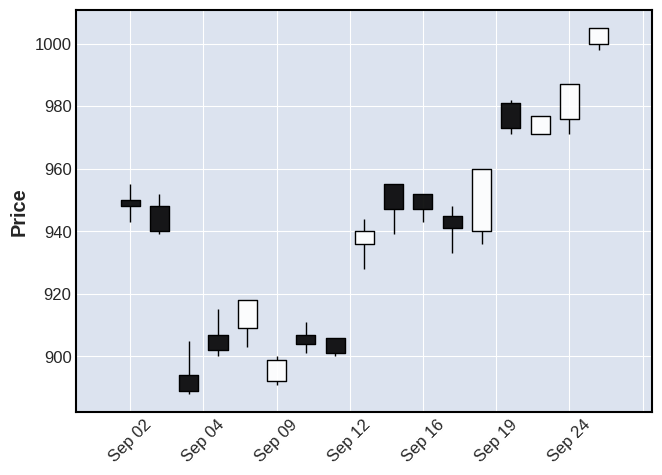

In [5]:
mpf.plot(df_twse, type='candle')

In [6]:
# 爬取 Yahoo 奇摩股價資料
def fetch_yahoo_stock_data(stock_id):
    url = f"https://tw.stock.yahoo.com/quote/{stock_id}.TW"

    # 發送請求，獲取 HTML 內容
    response = requests.get(url)

    # 檢查請求是否成功
    if response.status_code != 200:
        print(f"無法獲取 {stock_id} 的數據。")
        return pd.DataFrame()

    # 使用 BeautifulSoup 解析 HTML
    soup = BeautifulSoup(response.text, "html.parser")
    # 查找當前股價的元素（需要根據實際的 Yahoo 股價頁面 HTML 結構調整）
    price_tag = soup.find('span', {'class': 'Fz(32px)'})
    titleNum_tag = soup.find('span', {'class': 'Fz(24px)'})
    titleTxt_tag = soup.find('h1', {'class': 'Fz(24px)'})
    if price_tag and titleNum_tag and titleTxt_tag:
        # current_price = price_tag.text
        # print(f"個股: {titleTxt_tag.text}({titleNum_tag.text})")
        # print(f"目前股價: {current_price}")
        pass
    else:
        print(f"無法在頁面中找到 {stock_id} 的股價資料。")
        return pd.DataFrame()

    # 查找表格中的數據
    tables = soup.find_all('li', {'class': 'price-detail-item'})

    # 檢查是否有找到表格
    if not tables:
        print(f"無法在頁面中找到 {stock_id} 的股價資料。")
        return pd.DataFrame()

    # 儲存數據的字典
    stock_data = {}

    # 遍歷每個表格來提取相關數據
    for table in tables:
        spans = table.find_all('span')
        if len(spans) == 2:
            key = spans[0].text.strip()  # 第一個 span 作為鍵
            value = spans[1].text.strip()  # 第二個 span 作為值
            stock_data[key] = value

    # 打印提取出的數據
    # for key, value in stock_data.items():
    #     print(f"{key}: {value}")

    # 將數據轉換為 DataFrame
    df = pd.DataFrame(list(stock_data.items()), columns=["", '數值'])
    df = df.set_index("")

    return df

yahoo_df = fetch_yahoo_stock_data(stock_id)
yahoo_df

,數值
,
成交,"1,005"
開盤,"1,000"
最高,"1,005"
最低,998
均價,"1,000"
成交金額(億),392.28
昨收,987
總量,"39,210"
昨量,"26,678"
